In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_roi_t1t2_native_k5_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 304)
(631390, 1)
validation
(74368, 304)
(74368, 1)
test
(85358, 304)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 304)]             0         


 dense (Dense)               (None, 1024)              312320    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1001473 (3.82 MB)


Trainable params: 1001473 (3.82 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:27 - loss: 0.0674 - STD: 1.0643e-04 - MAE: 0.2505

 5/64 [=>............................] - ETA: 0s - loss: 0.0322 - STD: 1.0049e-04 - MAE: 0.1374  

 9/64 [===>..........................] - ETA: 0s - loss: 0.0298 - STD: 7.4824e-05 - MAE: 0.1294

13/64 [=====>........................] - ETA: 0s - loss: 0.0251 - STD: 6.7512e-05 - MAE: 0.1128

17/64 [======>.......................] - ETA: 0s - loss: 0.0233 - STD: 6.7704e-05 - MAE: 0.1135

21/64 [========>.....................] - ETA: 0s - loss: 0.0213 - STD: 6.8213e-05 - MAE: 0.1067

25/64 [==========>...................] - ETA: 1s - loss: 0.0204 - STD: 6.8272e-05 - MAE: 0.0993

29/64 [============>.................] - ETA: 1s - loss: 0.0195 - STD: 6.9704e-05 - MAE: 0.0940

33/64 [==============>...............] - ETA: 1s - loss: 0.0186 - STD: 7.2934e-05 - MAE: 0.0917

37/64 [================>.............] - ETA: 0s - loss: 0.0180 - STD: 7.7004e-05 - MAE: 0.0910

41/64 [==================>...........] - ETA: 0s - loss: 0.0175 - STD: 8.0916e-05 - MAE: 0.0891

45/64 [====================>.........] - ETA: 0s - loss: 0.0171 - STD: 8.4563e-05 - MAE: 0.0867

49/64 [=====================>........] - ETA: 0s - loss: 0.0167 - STD: 8.8848e-05 - MAE: 0.0851

53/64 [=======================>......] - ETA: 0s - loss: 0.0164 - STD: 9.3999e-05 - MAE: 0.0843

57/64 [=========================>....] - ETA: 0s - loss: 0.0162 - STD: 9.9506e-05 - MAE: 0.0836

61/64 [===========================>..] - ETA: 0s - loss: 0.0159 - STD: 1.0511e-04 - MAE: 0.0826

64/64 [==============================] - 4s 34ms/step - loss: 0.0158 - STD: 1.0957e-04 - MAE: 0.0820 - val_loss: 0.0168 - val_STD: 1.7109e-04 - val_MAE: 0.0777


Epoch 2/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0127 - STD: 2.0889e-04 - MAE: 0.0686

 5/64 [=>............................] - ETA: 0s - loss: 0.0127 - STD: 2.2197e-04 - MAE: 0.0705

 9/64 [===>..........................] - ETA: 0s - loss: 0.0127 - STD: 2.3367e-04 - MAE: 0.0715

13/64 [=====>........................] - ETA: 0s - loss: 0.0128 - STD: 2.4456e-04 - MAE: 0.0710

17/64 [======>.......................] - ETA: 0s - loss: 0.0127 - STD: 2.5639e-04 - MAE: 0.0704

21/64 [========>.....................] - ETA: 0s - loss: 0.0127 - STD: 2.6968e-04 - MAE: 0.0703

25/64 [==========>...................] - ETA: 0s - loss: 0.0127 - STD: 2.8395e-04 - MAE: 0.0704

29/64 [============>.................] - ETA: 0s - loss: 0.0127 - STD: 2.9958e-04 - MAE: 0.0703

33/64 [==============>...............] - ETA: 0s - loss: 0.0126 - STD: 3.1634e-04 - MAE: 0.0701

37/64 [================>.............] - ETA: 0s - loss: 0.0127 - STD: 3.3487e-04 - MAE: 0.0702

41/64 [==================>...........] - ETA: 0s - loss: 0.0126 - STD: 3.5493e-04 - MAE: 0.0702

45/64 [====================>.........] - ETA: 0s - loss: 0.0127 - STD: 3.7704e-04 - MAE: 0.0702

49/64 [=====================>........] - ETA: 0s - loss: 0.0126 - STD: 4.0155e-04 - MAE: 0.0701

54/64 [========================>.....] - ETA: 0s - loss: 0.0126 - STD: 4.3595e-04 - MAE: 0.0701

58/64 [==========================>...] - ETA: 0s - loss: 0.0126 - STD: 4.6723e-04 - MAE: 0.0701

62/64 [============================>.] - ETA: 0s - loss: 0.0126 - STD: 5.0188e-04 - MAE: 0.0700

64/64 [==============================] - 1s 16ms/step - loss: 0.0126 - STD: 5.2085e-04 - MAE: 0.0700 - val_loss: 0.0166 - val_STD: 9.7374e-04 - val_MAE: 0.0786


Epoch 3/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0119 - STD: 0.0012 - MAE: 0.0682

 5/64 [=>............................] - ETA: 0s - loss: 0.0123 - STD: 0.0013 - MAE: 0.0689

 9/64 [===>..........................] - ETA: 0s - loss: 0.0124 - STD: 0.0014 - MAE: 0.0694

13/64 [=====>........................] - ETA: 0s - loss: 0.0124 - STD: 0.0015 - MAE: 0.0694

17/64 [======>.......................] - ETA: 0s - loss: 0.0125 - STD: 0.0016 - MAE: 0.0696

21/64 [========>.....................] - ETA: 0s - loss: 0.0125 - STD: 0.0018 - MAE: 0.0698

25/64 [==========>...................] - ETA: 0s - loss: 0.0125 - STD: 0.0020 - MAE: 0.0697

29/64 [============>.................] - ETA: 0s - loss: 0.0124 - STD: 0.0022 - MAE: 0.0692

33/64 [==============>...............] - ETA: 0s - loss: 0.0123 - STD: 0.0025 - MAE: 0.0690

37/64 [================>.............] - ETA: 0s - loss: 0.0123 - STD: 0.0029 - MAE: 0.0689

41/64 [==================>...........] - ETA: 0s - loss: 0.0122 - STD: 0.0034 - MAE: 0.0686

45/64 [====================>.........] - ETA: 0s - loss: 0.0121 - STD: 0.0041 - MAE: 0.0682

49/64 [=====================>........] - ETA: 0s - loss: 0.0119 - STD: 0.0049 - MAE: 0.0678

54/64 [========================>.....] - ETA: 0s - loss: 0.0118 - STD: 0.0065 - MAE: 0.0671

58/64 [==========================>...] - ETA: 0s - loss: 0.0115 - STD: 0.0083 - MAE: 0.0663

62/64 [============================>.] - ETA: 0s - loss: 0.0112 - STD: 0.0107 - MAE: 0.0653

64/64 [==============================] - 1s 16ms/step - loss: 0.0111 - STD: 0.0121 - MAE: 0.0647 - val_loss: 0.0078 - val_STD: 0.0517 - val_MAE: 0.0514


Epoch 4/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0055 - STD: 0.0633 - MAE: 0.0458

 5/64 [=>............................] - ETA: 0s - loss: 0.0049 - STD: 0.0709 - MAE: 0.0437

 9/64 [===>..........................] - ETA: 0s - loss: 0.0043 - STD: 0.0766 - MAE: 0.0417

13/64 [=====>........................] - ETA: 0s - loss: 0.0039 - STD: 0.0809 - MAE: 0.0399

17/64 [======>.......................] - ETA: 0s - loss: 0.0036 - STD: 0.0844 - MAE: 0.0385

21/64 [========>.....................] - ETA: 0s - loss: 0.0033 - STD: 0.0874 - MAE: 0.0373

26/64 [===========>..................] - ETA: 0s - loss: 0.0031 - STD: 0.0904 - MAE: 0.0361

30/64 [=============>................] - ETA: 0s - loss: 0.0030 - STD: 0.0922 - MAE: 0.0355

34/64 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.0936 - MAE: 0.0349

38/64 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0949 - MAE: 0.0345

42/64 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.0959 - MAE: 0.0341

46/64 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0965 - MAE: 0.0337

50/64 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0970 - MAE: 0.0334

54/64 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0975 - MAE: 0.0332

58/64 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0979 - MAE: 0.0330

62/64 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0981 - MAE: 0.0328

64/64 [==============================] - 1s 16ms/step - loss: 0.0025 - STD: 0.0982 - MAE: 0.0327 - val_loss: 0.0023 - val_STD: 0.0841 - val_MAE: 0.0315


Epoch 5/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0295

 5/64 [=>............................] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0296

 9/64 [===>..........................] - ETA: 0s - loss: 0.0019 - STD: 0.1030 - MAE: 0.0296

13/64 [=====>........................] - ETA: 0s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0296

17/64 [======>.......................] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0296

21/64 [========>.....................] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0296

25/64 [==========>...................] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0296

29/64 [============>.................] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0295

33/64 [==============>...............] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0295

37/64 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0294

41/64 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0294

46/64 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0293

50/64 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0293

54/64 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0293

58/64 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0292

62/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0292

64/64 [==============================] - 1s 16ms/step - loss: 0.0019 - STD: 0.1039 - MAE: 0.0292 - val_loss: 0.0022 - val_STD: 0.0815 - val_MAE: 0.0307


Epoch 6/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0017 - STD: 0.1003 - MAE: 0.0283

 5/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0286

 9/64 [===>..........................] - ETA: 0s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0286

13/64 [=====>........................] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285

17/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0285

21/64 [========>.....................] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0285

25/64 [==========>...................] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0285

29/64 [============>.................] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285

33/64 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0285

37/64 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0285

41/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0285

46/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0285

50/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0285

54/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0285

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0285

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0284

64/64 [==============================] - 1s 16ms/step - loss: 0.0017 - STD: 0.1041 - MAE: 0.0284 - val_loss: 0.0020 - val_STD: 0.0843 - val_MAE: 0.0294


Epoch 7/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0017 - STD: 0.1030 - MAE: 0.0284

 5/64 [=>............................] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0280

 9/64 [===>..........................] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

13/64 [=====>........................] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

17/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0280

21/64 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0280

25/64 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0280

29/64 [============>.................] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0280

33/64 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0280

37/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0280

41/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0280

45/64 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0280

49/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0280

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0280

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0280

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0279

64/64 [==============================] - 1s 16ms/step - loss: 0.0017 - STD: 0.1044 - MAE: 0.0279 - val_loss: 0.0019 - val_STD: 0.0850 - val_MAE: 0.0288


Epoch 8/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0278

 5/64 [=>............................] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0276

10/64 [===>..........................] - ETA: 0s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0277

14/64 [=====>........................] - ETA: 0s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0277

18/64 [=======>......................] - ETA: 0s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0277

22/64 [=========>....................] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0278

26/64 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0278

30/64 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0278

34/64 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0278

38/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0278

42/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0278

46/64 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0278

49/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0278

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0278

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0278

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0278

64/64 [==============================] - 1s 16ms/step - loss: 0.0017 - STD: 0.1046 - MAE: 0.0278 - val_loss: 0.0018 - val_STD: 0.0857 - val_MAE: 0.0282


Epoch 9/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0274

 5/64 [=>............................] - ETA: 0s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0275

 9/64 [===>..........................] - ETA: 0s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0276

13/64 [=====>........................] - ETA: 0s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0275

17/64 [======>.......................] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0275

21/64 [========>.....................] - ETA: 0s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0274

25/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0274

29/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

33/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274

38/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0275

64/64 [==============================] - 1s 16ms/step - loss: 0.0016 - STD: 0.1048 - MAE: 0.0274 - val_loss: 0.0018 - val_STD: 0.0878 - val_MAE: 0.0279


Epoch 10/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0017 - STD: 0.1102 - MAE: 0.0278

 5/64 [=>............................] - ETA: 0s - loss: 0.0016 - STD: 0.1069 - MAE: 0.0273

 9/64 [===>..........................] - ETA: 0s - loss: 0.0016 - STD: 0.1065 - MAE: 0.0273

13/64 [=====>........................] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

17/64 [======>.......................] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0272

21/64 [========>.....................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

25/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0273

29/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0272

33/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

37/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

41/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

45/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

64/64 [==============================] - 1s 16ms/step - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272 - val_loss: 0.0017 - val_STD: 0.0864 - val_MAE: 0.0279


Epoch 11/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

 5/64 [=>............................] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0274

 9/64 [===>..........................] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

13/64 [=====>........................] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

17/64 [======>.......................] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

21/64 [========>.....................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

25/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

29/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

33/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

37/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

64/64 [==============================] - 1s 16ms/step - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271 - val_loss: 0.0018 - val_STD: 0.0849 - val_MAE: 0.0279


Epoch 12/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0270

 6/64 [=>............................] - ETA: 0s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0271

10/64 [===>..........................] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0271

14/64 [=====>........................] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0270

18/64 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0269

22/64 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0269

26/64 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0269

30/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0269

34/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0269

38/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0269

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0269

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0269

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0269

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0268

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0268

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0268

64/64 [==============================] - 1s 16ms/step - loss: 0.0016 - STD: 0.1052 - MAE: 0.0268 - val_loss: 0.0017 - val_STD: 0.0864 - val_MAE: 0.0272


Epoch 13/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0268

 5/64 [=>............................] - ETA: 0s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0269

 9/64 [===>..........................] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0268

13/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0267

17/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0267

21/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0267

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

29/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

33/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0268

37/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0268

41/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0268

45/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0267

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0267

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0267

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0267

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0267

64/64 [==============================] - 1s 15ms/step - loss: 0.0016 - STD: 0.1053 - MAE: 0.0267 - val_loss: 0.0017 - val_STD: 0.0875 - val_MAE: 0.0275


Epoch 14/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0266

 6/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

10/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

14/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

18/64 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

22/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

26/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

30/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

38/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0268

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0268

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0268

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0267

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

64/64 [==============================] - 1s 16ms/step - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267 - val_loss: 0.0017 - val_STD: 0.0878 - val_MAE: 0.0270


Epoch 15/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0016 - STD: 0.1087 - MAE: 0.0271

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0265

 9/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

13/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

17/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

21/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

29/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

64/64 [==============================] - 1s 16ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265 - val_loss: 0.0017 - val_STD: 0.0859 - val_MAE: 0.0276


Epoch 16/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0264

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0264

 9/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

13/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

17/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

21/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

29/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

64/64 [==============================] - 1s 16ms/step - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266 - val_loss: 0.0016 - val_STD: 0.0863 - val_MAE: 0.0268


Epoch 17/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0262

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

 9/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

13/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

17/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0264

21/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0264

29/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0264

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

64/64 [==============================] - 1s 16ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263 - val_loss: 0.0016 - val_STD: 0.0882 - val_MAE: 0.0267


Epoch 18/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0015 - STD: 0.1093 - MAE: 0.0262

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0263

 8/64 [==>...........................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0261

12/64 [====>.........................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

16/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

20/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

24/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

28/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

64/64 [==============================] - 1s 16ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260 - val_loss: 0.0016 - val_STD: 0.0875 - val_MAE: 0.0266


Epoch 19/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1078 - MAE: 0.0261

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1076 - MAE: 0.0261

 9/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0261

13/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0260

17/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0260

21/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0260

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

29/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260

64/64 [==============================] - 1s 16ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260 - val_loss: 0.0016 - val_STD: 0.0872 - val_MAE: 0.0269


Epoch 20/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0257

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0262

 9/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0261

13/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

17/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0260

21/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0260

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260

29/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0260

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0260

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0259

64/64 [==============================] - 1s 15ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0259 - val_loss: 0.0016 - val_STD: 0.0853 - val_MAE: 0.0266


Epoch 21/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0259

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0258

 9/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0258

13/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0258

17/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0258

21/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0258

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0258

29/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0258

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0258

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0258

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0258

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0258

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0258

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0258

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0258

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0258

64/64 [==============================] - 1s 16ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0258 - val_loss: 0.0016 - val_STD: 0.0892 - val_MAE: 0.0263


Epoch 22/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0256

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1041 - MAE: 0.0256

 9/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0257

13/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0258

17/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0258

21/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0258

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0258

29/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0257

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0257

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0257

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0257

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0257

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0257

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0257

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0257

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0257

64/64 [==============================] - 1s 16ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0257 - val_loss: 0.0016 - val_STD: 0.0889 - val_MAE: 0.0263


Epoch 23/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0014 - STD: 0.1098 - MAE: 0.0257

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1069 - MAE: 0.0257

 9/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0256

13/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0256

17/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0256

21/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

29/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0256

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0257

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0256

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0257

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0257

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0257

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0256

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0257

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0257

64/64 [==============================] - 1s 16ms/step - loss: 0.0015 - STD: 0.1060 - MAE: 0.0257 - val_loss: 0.0016 - val_STD: 0.0884 - val_MAE: 0.0262


Epoch 24/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0255

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0254

10/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

14/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0255

18/64 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0256

22/64 [=========>....................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

26/64 [===========>..................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

30/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

42/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0256

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0256

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

64/64 [==============================] - 1s 16ms/step - loss: 0.0015 - STD: 0.1060 - MAE: 0.0256 - val_loss: 0.0016 - val_STD: 0.0881 - val_MAE: 0.0264


Epoch 25/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1107 - MAE: 0.0255

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0253

 9/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

13/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0254

17/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0255

21/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0255

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0255

29/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0255

33/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0257

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0256

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0257

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0257

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0257

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0257

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0257

64/64 [==============================] - 1s 16ms/step - loss: 0.0015 - STD: 0.1059 - MAE: 0.0257 - val_loss: 0.0016 - val_STD: 0.0883 - val_MAE: 0.0262


Epoch 26/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1083 - MAE: 0.0255

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1073 - MAE: 0.0257

 9/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0256

13/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0255

18/64 [=======>......................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

22/64 [=========>....................] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

26/64 [===========>..................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

30/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

42/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

64/64 [==============================] - 1s 16ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254 - val_loss: 0.0016 - val_STD: 0.0872 - val_MAE: 0.0268


Epoch 27/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0256

 6/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0259

10/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0258

14/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

18/64 [=======>......................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

22/64 [=========>....................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

26/64 [===========>..................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

30/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

42/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0255

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

64/64 [==============================] - 1s 16ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255 - val_loss: 0.0016 - val_STD: 0.0880 - val_MAE: 0.0266


Epoch 28/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0255

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1036 - MAE: 0.0252

 9/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0256

13/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0256

18/64 [=======>......................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0257

22/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0259

26/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

30/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0259

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0258

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0257

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0257

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

64/64 [==============================] - 1s 15ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255 - val_loss: 0.0016 - val_STD: 0.0877 - val_MAE: 0.0269


Epoch 29/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0258

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

 9/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0254

13/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0254

17/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0253

22/64 [=========>....................] - ETA: 0s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0253

26/64 [===========>..................] - ETA: 0s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0253

30/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0253

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0252

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

42/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

64/64 [==============================] - 1s 15ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252 - val_loss: 0.0016 - val_STD: 0.0889 - val_MAE: 0.0266


Epoch 30/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1078 - MAE: 0.0253

 9/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1076 - MAE: 0.0251

13/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0250

17/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0251

21/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

29/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

33/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

64/64 [==============================] - 1s 15ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255 - val_loss: 0.0016 - val_STD: 0.0876 - val_MAE: 0.0265


Epoch 31/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0254

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0254

 9/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

13/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0253

17/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0254

21/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

29/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

42/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

64/64 [==============================] - 1s 16ms/step - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252 - val_loss: 0.0016 - val_STD: 0.0871 - val_MAE: 0.0264


Epoch 32/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0254

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

 9/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0253

13/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

17/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0251

21/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0251

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0251

30/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0251

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0251

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

42/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0251

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0251

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

64/64 [==============================] - 1s 15ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252 - val_loss: 0.0018 - val_STD: 0.0862 - val_MAE: 0.0292


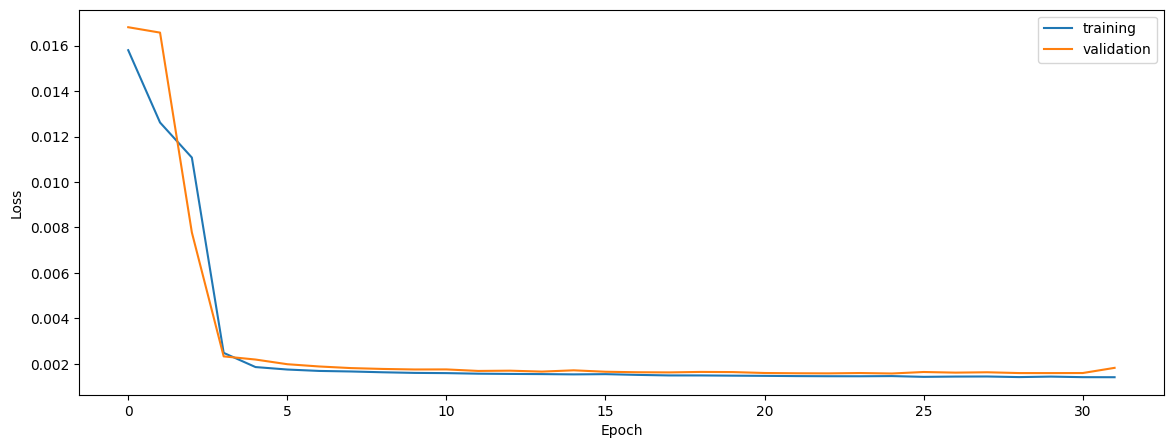

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


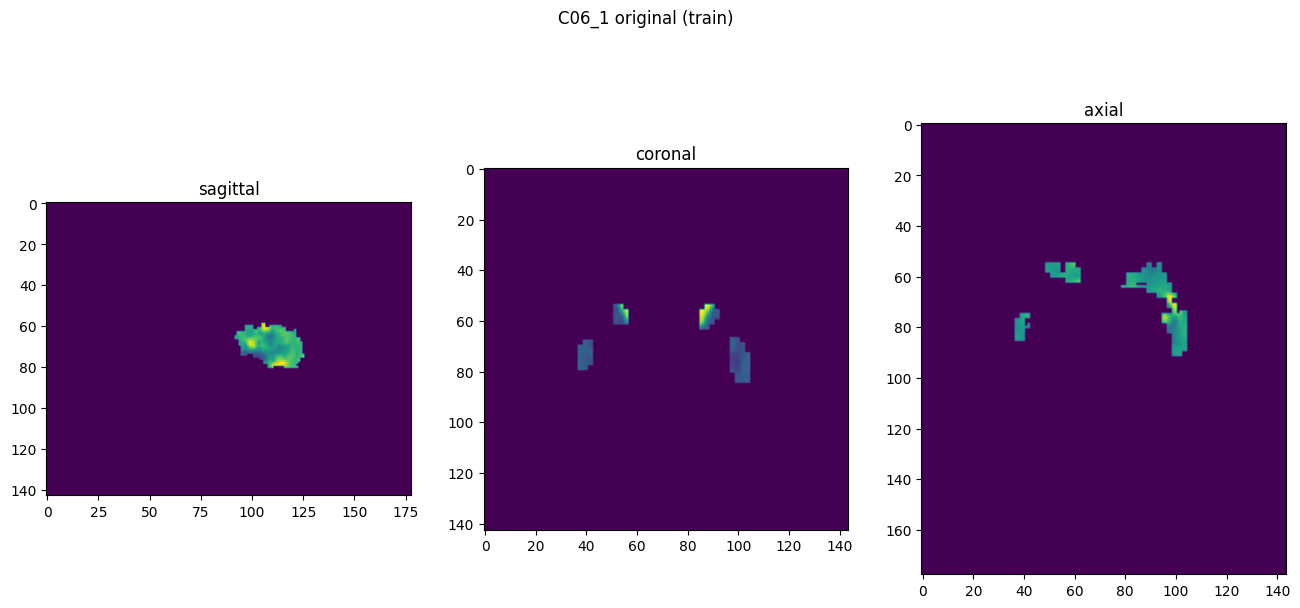

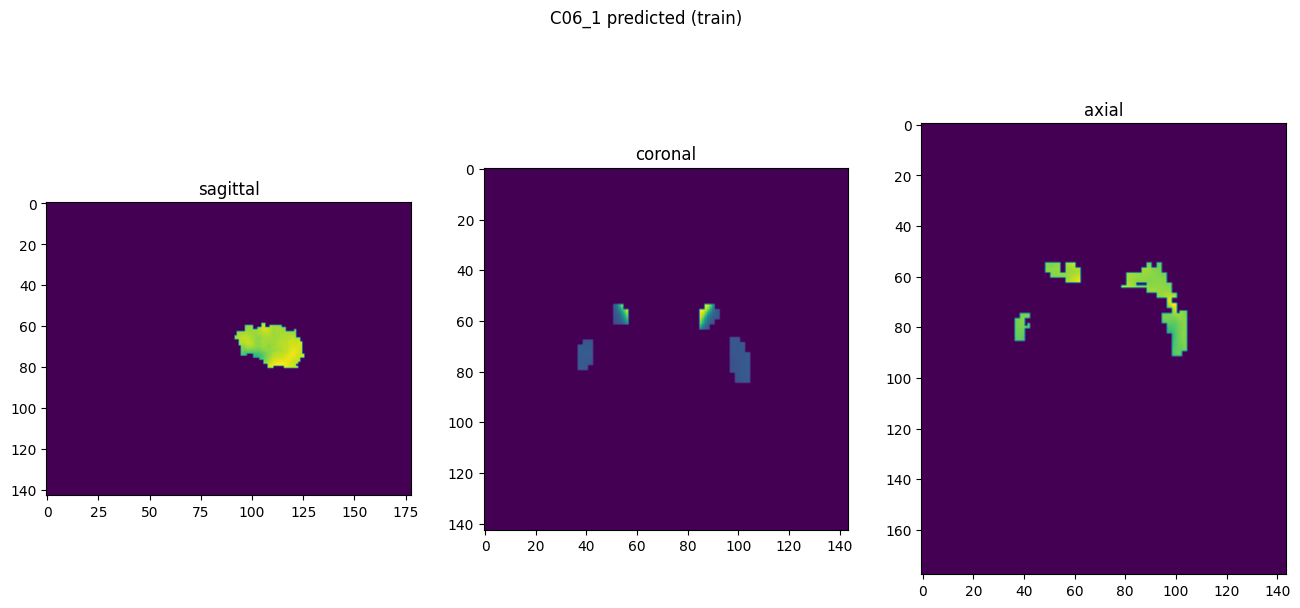

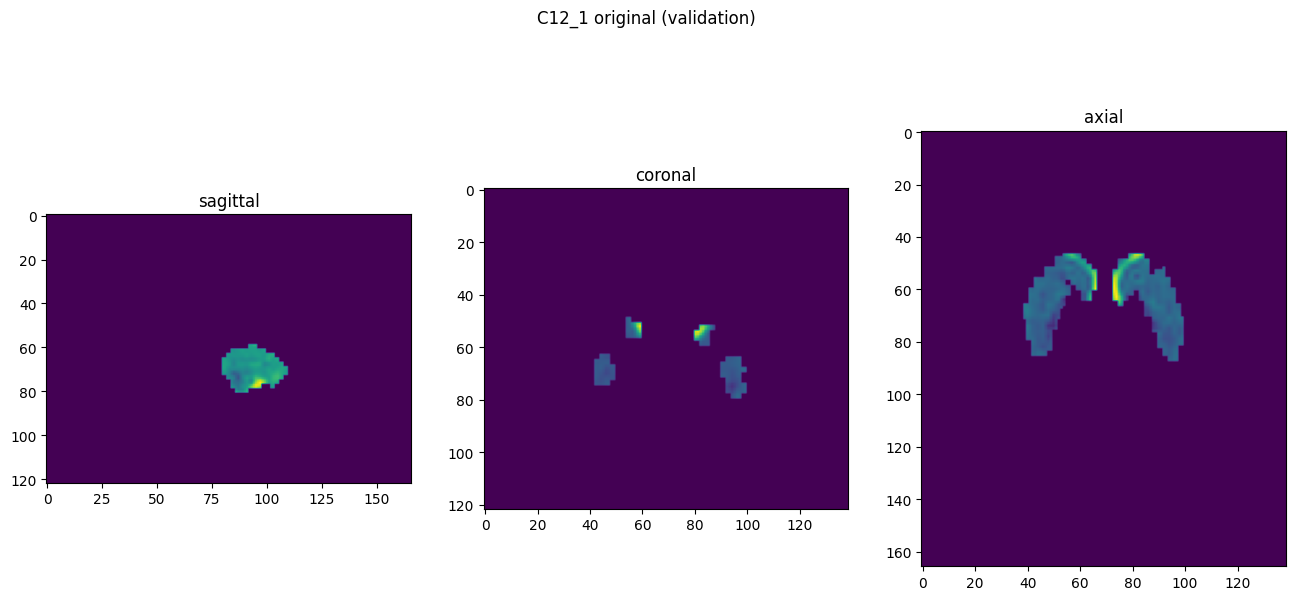

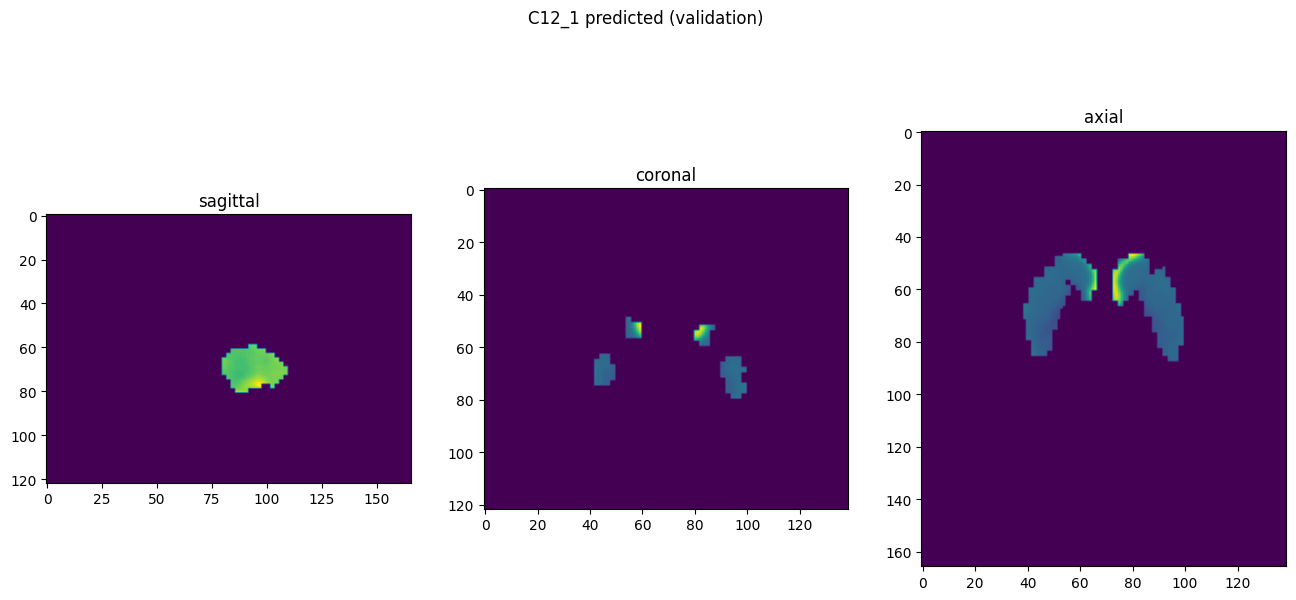

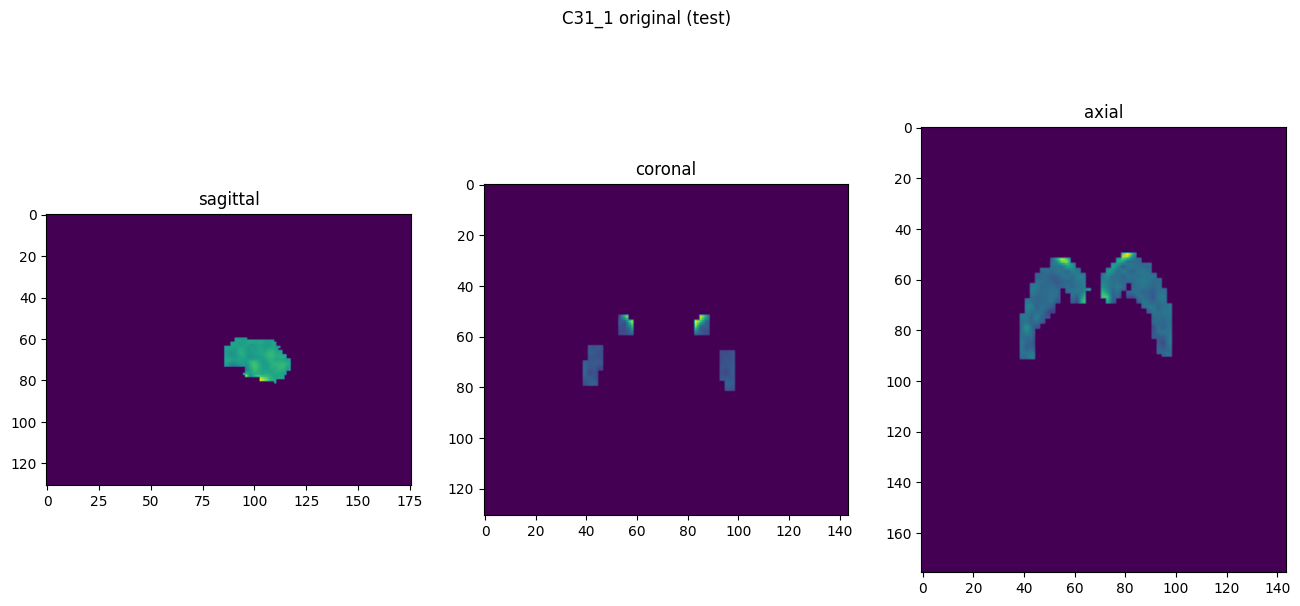

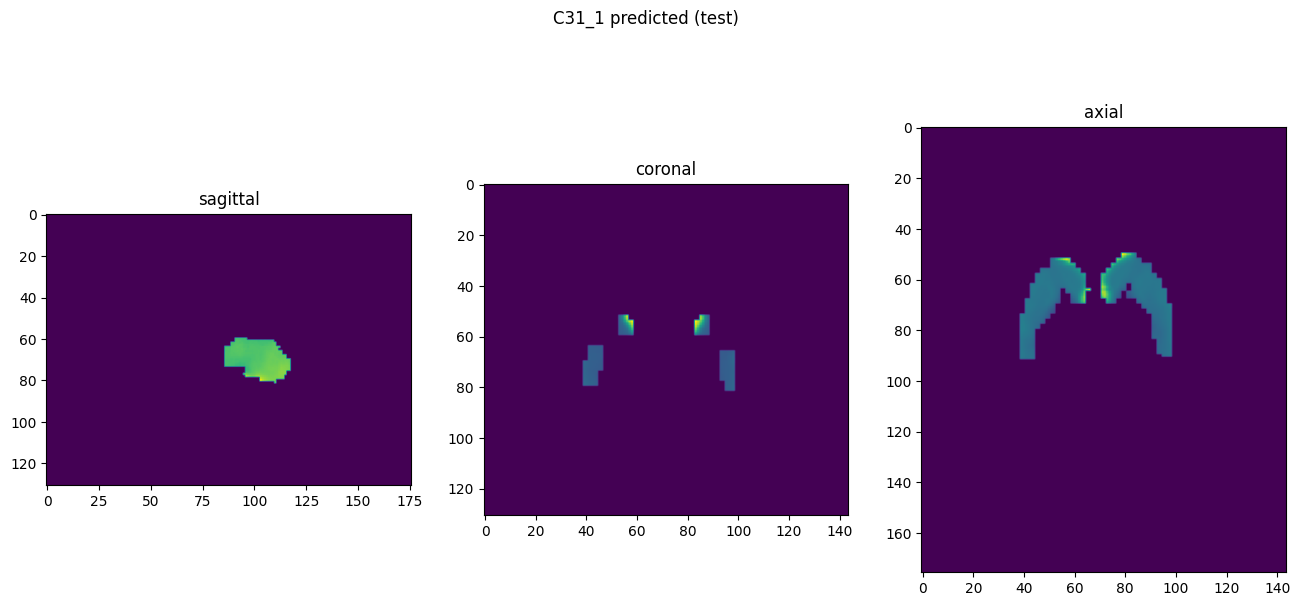

In [10]:
showResults(model, gen, threshold=None, background=False)